In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from time import time
from functions import utils
import os.path as path

## User input

In [2]:
sample_file = utils.gui_fname().decode("utf-8")
background_filename = utils.gui_fname().decode("utf-8")
tokens = sample_file.split('/')
base = path.basename(sample_file)
abs_dir = path.dirname(sample_file)
prefix = base.split('.')[0]
sample_prefix = abs_dir + '/' + prefix
print("Sample: \n%s" %sample_file)
print("Background: \n%s" %background_filename)

Sample: 
E:/Ashlee/PacBio/20190215_D1-3_titration/2x_neut_250_pM_D1-3/m190215_204223_42131_c000471022559900001500000112312100_s1_p0.trc.h5
Background: 
E:/Ashlee/PacBio/20190215_D1-3_titration/PIB_blank/m190215_194458_42131_c000471012559900001500000112312130_s1_p0_background.csv


In [3]:
# sample_prefix = 'C:\\Data\\Ashlee\\20190215_D1-3_titration\\2x_neut_250_pM_D1-3\\m190215_204223_42131_c000471022559900001500000112312100_s1_p0'
# background_filename = "C:\\Data\\Ashlee\\20190215_D1-3_titration\\PIB_blank\\m190215_194458_42131_c000471012559900001500000112312130_s1_p0_background.csv"
color1 = 0
color2 = 2

leakage = np.zeros((4, 4))
background = [0, 0, 0, 0]
gamma = np.ones((4,))
leakage = np.array([[0.        , 0.48921841, 0.09134705, 0.02373513],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.3349036856391455],
       [0.        , 0.        , 0.        , 0.        ]])
gamma = np.ones((4,))
gamma[2] = 1.3709926961993117

## Load data

In [4]:
start = time()
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

bg_file = open(background_filename, "rb")
bg = np.loadtxt(bg_file, delimiter=",")

print("Time passed: " + str(time() - start))

Time passed: 1.2534000873565674


In [ ]:
# traces = raw_traces # skipping decode step to save memory

## View a trace

In [ ]:
plt.figure(figsize=(13, 4))
traceID = np.random.randint(0, n_traces)
utils.plot_one_trace(raw_traces, traceID, time_axis, range(340, n_frames), colors)

In [5]:
start_frame = 340
end_frame = n_frames - 1

## Preprocessing

In [6]:
foi = range(start_frame, end_frame) # frames of interest
n_frames = len(foi)

# first_10_frames = np.zeros((n_traces, 4, 10), dtype=np.uint8)
first_10_frames = np.array(raw_traces[:, :, range(start_frame, start_frame + 10)], dtype=np.uint8)

corrected_f10f = np.zeros(first_10_frames.shape)
for i in range(n_traces):
    corrected_f10f[i] = decode_array[first_10_frames[i]]

avg_intens = np.mean(corrected_f10f, axis=2)
avg_intens_bgs = np.zeros((n_traces, 4))

for i in range(n_traces):
    new_intens = avg_intens[i] - bg[i]
    avg_intens_bgs[i]= new_intens

In [7]:
avg_intens_bgs2 = np.array(avg_intens_bgs)

for i in range(n_traces):
    avg_intens_bgs2[i, 0]= avg_intens_bgs[i, 0] + 35

In [16]:
bg[:, 0] = bg[:, 0] + 35

## Plot intensity distributions

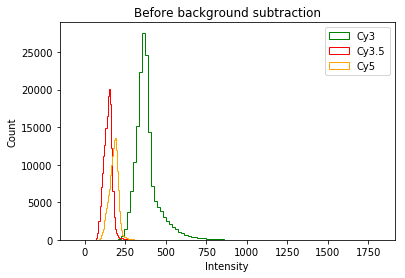

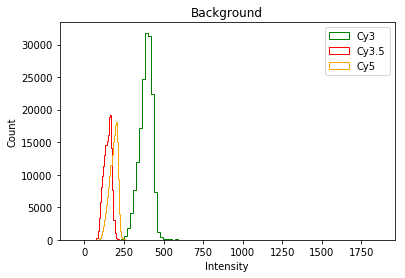

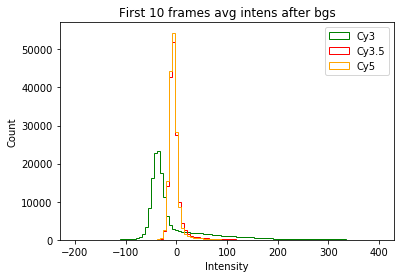

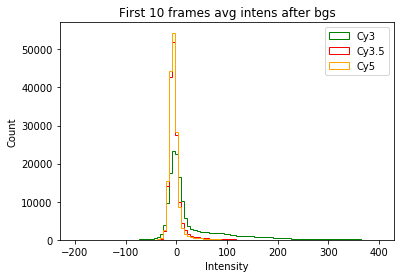

In [8]:
plt.figure()
for i in [0, 2, 3]:
    avg_intens_i = avg_intens.T[i]
    min_i = min(avg_intens_i)
    max_i = max(avg_intens_i)
    plt.hist(avg_intens_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Before background subtraction")
plt.legend(lasers)
plt.savefig(sample_prefix + '_intensity_hist.png', dpi=200)


plt.figure()
for i in [0, 2, 3]:
    bg_i = bg.T[i]
    min_i = min(bg_i)
    max_i = max(bg_i)
    plt.hist(bg_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("Background")
plt.legend(lasers)
plt.savefig(sample_prefix + "_background_hist.png", dpi=200)

plt.figure()
for i in [0, 2, 3]:
    color_i = avg_intens_bgs.T[i]
    min_i = -200
    max_i = 400
    plt.hist(color_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("First 10 frames avg intens after bgs")
plt.legend(lasers)
# plt.savefig(sample_prefix + '_intensity_hist_after_bgs.png', dpi=200)

plt.figure()
for i in [0, 2, 3]:
    color_i = avg_intens_bgs2.T[i]
    min_i = -200
    max_i = 400
    plt.hist(color_i, bins=100, range=[min_i, max_i], histtype='step', color=colors[i])
    
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.title("First 10 frames avg intens after bgs")
plt.legend(lasers)
plt.savefig(sample_prefix + '_intensity_hist_after_bgs.png', dpi=200)

In [ ]:
print("Raw data")
plt.figure(figsize=(7.5, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
plt.title("Before filtering")
plt.savefig(sample_prefix + '_grid.png')
plt.show()

print("Background subtracted data")
plt.figure(figsize=(7.5, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], hole_status)
    plt.scatter(hole_xy_plot[:, 0], hole_xy_plot[:, 1], 1, avg_intens_bgs2.T[i])
    plt.title(lasers[i] + ' intensity')
    plt.colorbar()
plt.subplots_adjust(hspace=0.3)
# plt.title("Before background subtraction")
plt.savefig(sample_prefix + '_grid_bgs.png')
plt.show()

## Filtering for wells that have desired intensity

In [14]:
def decode_and_plot(traces, traceID, decode_array, colors, foi, background, gamma, leakage, channels, lasers):
#     channels = range(4)
    trace = decode_array[traces[traceID, :, foi]]
    plt.figure(figsize=(13,4))
    
    for i in channels:
        trace[i] = trace[i] - background[traceID, i]
        trace[i] = trace[i] * gamma[i]
        for j in channels:
            trace[i] = trace[i] - trace[j] * leakage[j, i]
    
    for j in channels:
        plt.plot(time_axis[foi], trace[j], color=colors[j], linewidth=0.5, alpha=1)

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity')
    plt.legend(lasers, bbox_to_anchor=(0.75, 0.5, 0.5, 0.5))

In [ ]:
def plot_one_trace_bgs(data, traceID, time_axis, background, foi):
#     plt.figure(figsize=(15, 2))
    trc = data[traceID, :, foi]
    corrected = np.zeros((4, n_frames))
    for j in [0, 2]:
        corrected[j] = trc[j] - bg[traceID, j]
        if j > 0:
            corrected[j] = corrected[j] - leakage[0, j] * corrected[0]
        if j > 1:
            corrected[j] = corrected[j] - leakage[1, j] * corrected[1]
        if j > 2:
            corrected[j] = corrected[j] - leakage[2, j] * corrected[2]
        plt.plot(time_axis[foi], corrected[j] , c=colors[j], linewidth=.5)
        plt.xlabel('Time (s)')
        plt.ylabel('Intensity')
        plt.title('Trace ' + str(traceID))

In [25]:
channel = 2
low = 40
high = 200
sele_traces = []

for i in range(n_traces):
    if avg_intens_bgs[i, channel] > low and avg_intens_bgs[i, channel] < high:
        sele_traces.append(i)

print("%d traces have desired intensity." %len(sele_traces))

4046 traces have desired intensity.


Showing 9 traces.


<Figure size 936x144 with 0 Axes>

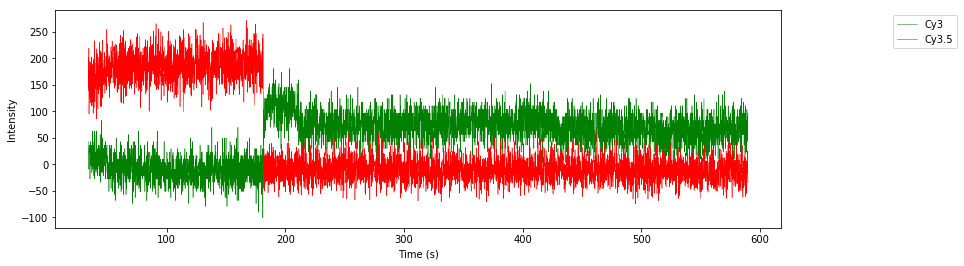

<Figure size 936x144 with 0 Axes>

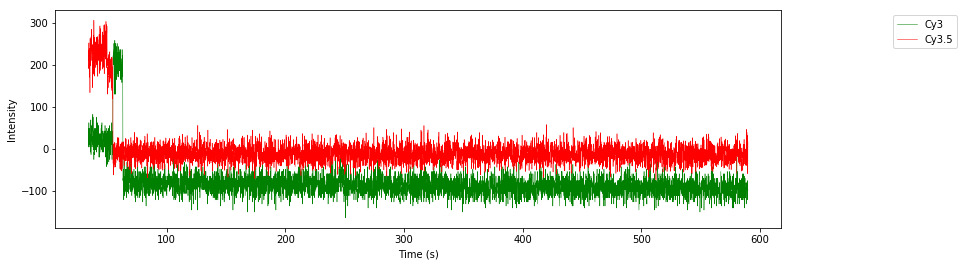

<Figure size 936x144 with 0 Axes>

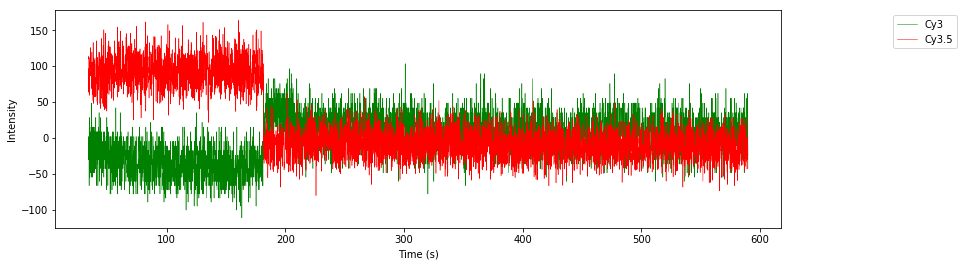

<Figure size 936x144 with 0 Axes>

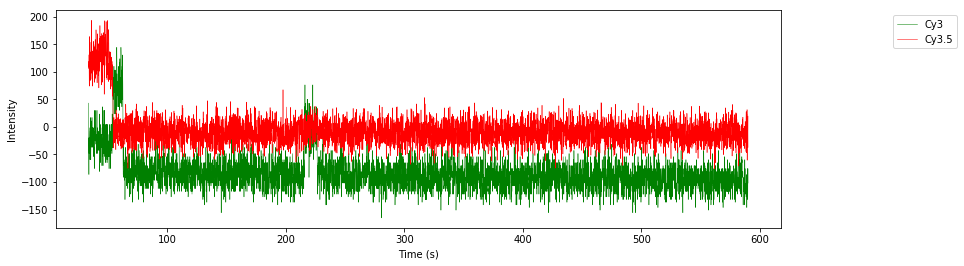

<Figure size 936x144 with 0 Axes>

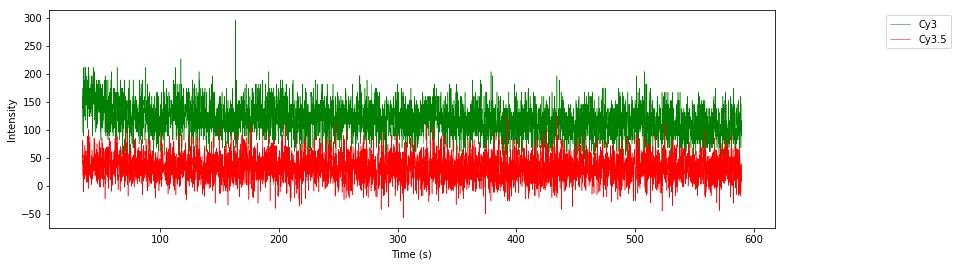

<Figure size 936x144 with 0 Axes>

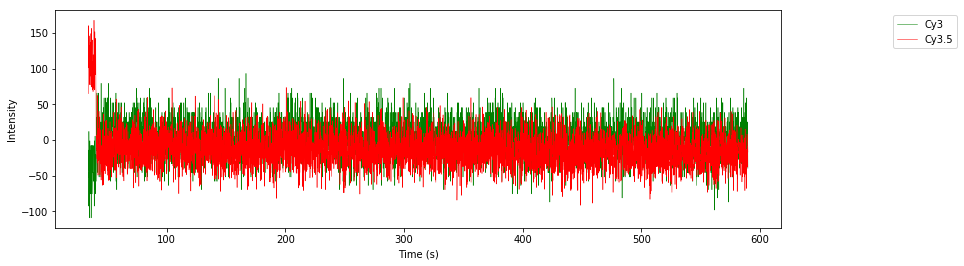

<Figure size 936x144 with 0 Axes>

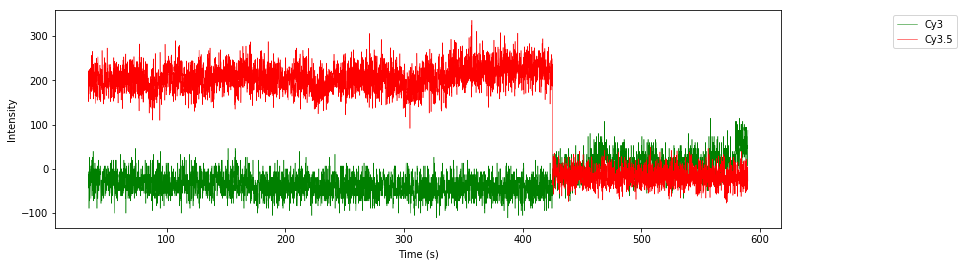

<Figure size 936x144 with 0 Axes>

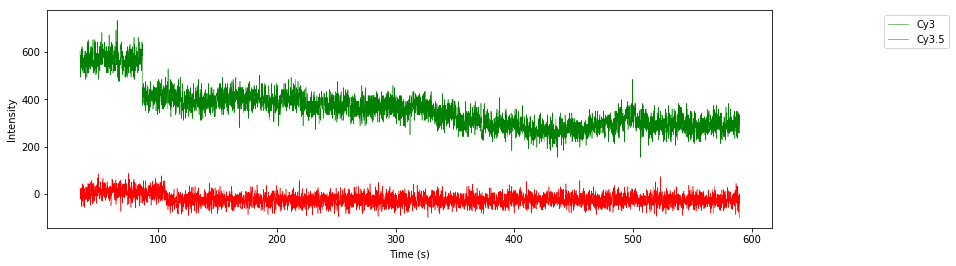

<Figure size 936x144 with 0 Axes>

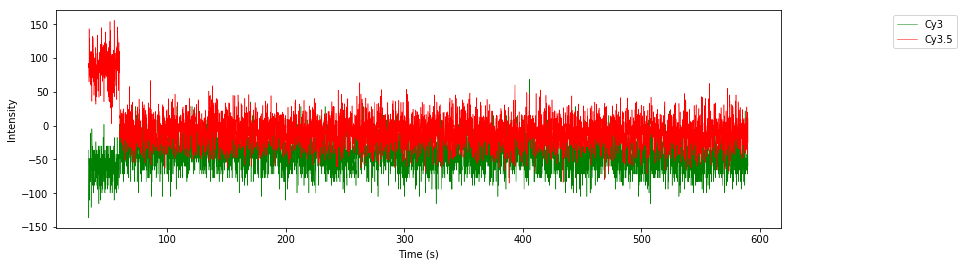

In [23]:
# display selected traces
count = 0
end_high = 20

for i in range(500, 510):
    traceID = sele_traces[i]
    last_10_frames = decode_array[raw_traces[traceID, channel, [end_frame-10, end_frame]]] - bg[traceID, channel]
    end_avg = np.mean(last_10_frames)
    if end_avg < end_high:
        plt.figure(figsize=(13,2))
        decode_and_plot(raw_traces, traceID, decode_array, colors, foi, bg, gamma, leakage, [0, 2], lasers)
        count += 1

print("Showing %d traces." %count)

In [27]:
# count traces that bleached
count = 0
end_high = 20

for traceID in sele_traces:
    last_10_frames = decode_array[raw_traces[traceID, channel, [end_frame-10, end_frame]]] - bg[traceID, channel]
    end_avg = np.mean(last_10_frames)
    if end_avg < end_high:
        count += 1

print("%d traces satisfied constraints." %count)


3414 traces satisfied constraints.


In [ ]:
# randomly display selected traces
# count = 0
end_high = 10

for i in range(0, 1):
    traceID = np.random.choice(sele_traces)
    last_10_frames = raw_traces[traceID, channel, [end_frame-10, end_frame]] - bg[traceID, channel]
    end_avg = np.mean(last_10_frames)
    if end_avg < end_high:
        plt.figure(figsize=(13,2))
        plot_one_trace_bgs(raw_traces, traceID, time_axis, bg, foi)
#         count += 1

# print("Showing %d traces." %count)

In [ ]:
aib_leakage = np.array(avg_intens_bgs2)
for i in [0, 2, 3]:
    if i > 0:
        aib_leakage[:, i] = aib_leakage[:, i] - aib_leakage[:, 0] * leakage[0, i]
    if i > 2:
        aib_leakage[:, i] = aib_leakage[:, i] - aib_leakage[:, 2] * leakage[2, i]

sele_cy3 = aib_leakage[sele_traces, 0]
sele_cy5 = aib_leakage[sele_traces, 2]
sele_cy55 = aib_leakage[sele_traces, 3]

plt.figure(figsize = (10, 5))
h = plt.hist(sele_cy3, bins=50, alpha = 0.7, color = 'g')
h = plt.hist(sele_cy3 + sele_cy5, bins=50, alpha = 0.7, color = 'b')
h = plt.hist(sele_cy5, bins=50, alpha = 0.7, color = 'r')
# h = plt.hist(sele_cy55, bins=50, alpha = 0.7, color = 'orange')

In [ ]:
cy3_lo = -100
cy3_hi = 1000

cy5_lo = -100
cy5_hi = 1000

cy55_lo = -100
cy55_hi = 1000

cy3cy5_lo = 10
cy3cy5_hi = 60

sele_traces2 = []
for i in range(len(sele_traces)):
    traceID = sele_traces[i]
    cy3_i = avg_intens_bgs[traceID, 0]
    cy5_i = avg_intens_bgs[traceID, 2]
    cy55_i = avg_intens_bgs[traceID,3]
    cy3cy5_i = cy3_i + cy5_i
    if cy3_i > cy3_lo and cy3_i < cy3_hi:
        if cy5_i > cy5_lo and cy5_i < cy5_hi:
            if cy55_i > cy55_lo and cy55_i < cy55_hi:
                if cy3cy5_i > cy3cy5_lo and cy3cy5_i < cy3cy5_hi:
                    sele_traces2.append(traceID)

In [ ]:
sele_cy3 = aib_leakage[sele_traces2, 0]
sele_cy5 = aib_leakage[sele_traces2, 2]
sele_cy55 = aib_leakage[sele_traces2, 3]

In [ ]:
fret3_5 = sele_cy5 / (sele_cy3 + sele_cy5)
# fret3_55 = sele_cy55 / (sele_cy3 + sele_cy55)
# fret5_55 = sele_cy5 / (sele_cy5 + sele_cy55)

h = plt.hist(fret3_5, bins= 40, range=[-0.1, 1])

In [ ]:
len(sele_traces2)